# Analysis of Inter-Annotator Agreement versus agreement with GPT-4o

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Create a function which calculates the Krippendorff's alpha:
def krip_alpha(table, an1_column, an2_column):
    """
    Args:
    - table (DataFrame): This function takes a dataframe where the first column should be labels by the first annotator and the second labels by the other annotator.
    - an1_column: Name of the column with labels of the 1st annotator.
    - an2_column: Name of the column with labels of the 2nd annotator.

    This function prints out the nominal Krippendorff's alpha.
    """
    import krippendorff
    import numpy as np
    from collections import Counter

    # Drop NaN values if there are any
    #table = table.dropna()

    # Use only the first 2 columns
    table = table[[an1_column, an2_column]]

    table_to_list = []

    for column in table.columns:
        column_list = table[column].tolist()
        table_to_list.append(column_list)

    labels = table_to_list

    print("Number of instances: ",len(labels[0]))

    distr=dict([(b,a) for a,b in enumerate(list(Counter(labels[0]+labels[1]).keys()))])

    labels[0]=[distr[e] for e in labels[0]]
    labels[1]=[distr[e] for e in labels[1]]

    #Krippendorff's alpha
    krip = krippendorff.alpha(reliability_data=labels,level_of_measurement='nominal')
    print("Krippendorff's Alpha: ", krip)
    return krip

Prepare the sample

In [ ]:
# Open the final test sample

test_df = pd.read_json("MaCoCu-manually-annotated-test-set-with-preds.json", orient="records", lines=True)

print(test_df.shape)

test_df.head(3)

(1129, 93)


,initial_index,document_id,genre,text,pred_GPT4o,IPTC_true_multilabel,lang,batch,translation,random_pick-0,...,pred_5k-el-model-v3,match_5k-el-model-v3,pred_5k-hr-model-v2,match_5k-hr-model-v2,pred_5k-hr-model-v3,match_5k-hr-model-v3,2nd_annotation_multilabel,2nd_annotation,IPTC_true,1st_annotator_run2
0,824,CLASSLA-web.hr.3842863,News,Iza kamere\n\nFilmsku družinu ZAG posjetila je...,"arts, culture, entertainment and media","[arts, culture, entertainment and media]",hr,1st,None,"arts, culture, entertainment and media",...,"arts, culture, entertainment and media",yes,education,no,education,no,no,None,"arts, culture, entertainment and media",None
1,1949,CLASSLA-web.hr.4597011,News,Učenici osmih razreda nedavno su u sklopu tere...,education,[education],hr,1st,None,education,...,education,yes,education,yes,education,yes,no,None,education,None
2,800,CLASSLA-web.hr.4308755,News,Moto 360 – novi detalji\n\nMoto 360 već nekoli...,science and technology,[science and technology],hr,1st,Moto 360 – new details\n\nThe Moto 360 has bee...,science and technology,...,science and technology,yes,science and technology,yes,science and technology,yes,"[economy, business and finance]","economy, business and finance",science and technology,"economy, business and finance"


In [ ]:
ann_table = test_df[["pred_GPT4o", "IPTC_true", "2nd_annotation"]]
ann_table.head(3)

,pred_GPT4o,IPTC_true,2nd_annotation
0,"arts, culture, entertainment and media","arts, culture, entertainment and media",None
1,education,education,None
2,science and technology,science and technology,"economy, business and finance"


In [ ]:
# Use only instances that are annotated by the 2nd annotator
ann_table.dropna(inplace=True)

ann_table.shape

/tmp/ipykernel_3646982/733987210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ann_table.dropna(inplace=True)


(339, 3)

In [ ]:
agreement_results = {}

In [ ]:
from itertools import combinations, combinations_with_replacement

pairs = list(combinations(['pred_GPT4o', 'IPTC_true', '2nd_annotation'], 2))
pairs

[('pred_GPT4o', 'IPTC_true'),
 ('pred_GPT4o', '2nd_annotation'),
 ('IPTC_true', '2nd_annotation')]

In [ ]:
for pair in pairs:
	agreement_results[f"{pair[0]} & {pair[1]}"] = krip_alpha(ann_table, pair[0], pair[1])

agreement_results

Number of instances:  339
Krippendorff's Alpha:  0.692998935727176
Number of instances:  339
Krippendorff's Alpha:  0.7523992500173606
Number of instances:  339
Krippendorff's Alpha:  0.7276220865704772


{'pred_GPT4o & IPTC_true': 0.692998935727176,
 'pred_GPT4o & 2nd_annotation': 0.7523992500173606,
 'IPTC_true & 2nd_annotation': 0.7276220865704772}

In [ ]:
print(pd.DataFrame({"pair": list(agreement_results.keys()), "nominal Krippendorff Alpha": list(agreement_results.values())}).sort_values(by="nominal Krippendorff Alpha", ascending=False).to_markdown(index=False))

| pair                        |   nominal Krippendorff Alpha |
|:----------------------------|-----------------------------:|
| pred_GPT4o & 2nd_annotation |                     0.752399 |
| IPTC_true & 2nd_annotation  |                     0.727622 |
| pred_GPT4o & IPTC_true      |                     0.692999 |


### Inter-Annotator Agreement on Label-Level

Calculate agreement for each label

In [ ]:
# Rename the columns
ann_table.rename(columns={"pred_GPT4o": "GPT-4o", "IPTC_true": "1st ann", "2nd_annotation": "2nd ann"}, inplace=True)
ann_table.head(2)

In [ ]:
labels = ['disaster, accident and emergency incident',
 'human interest',
 'politics',
 'education',
 'crime, law and justice',
 'economy, business and finance',
 'conflict, war and peace',
 'arts, culture, entertainment and media',
 'labour',
 'weather',
 'religion',
 'society',
 'health',
 'environment',
 'lifestyle and leisure',
 'science and technology',
 'sport']

In [ ]:
from itertools import combinations, combinations_with_replacement

pairs = list(combinations(['GPT-4o', '1st ann', '2nd ann'], 2))
pairs

[('GPT-4o', '1st ann'), ('GPT-4o', '2nd ann'), ('1st ann', '2nd ann')]

In [ ]:
label_agreement_results = {}

In [ ]:
for label in labels:
	label_dict = {}
	current_label_table = ann_table.copy()

	# Create a label binary dataframe where all labels that are not the current label are renamed to "other"
	for column in ['GPT-4o', '1st ann', '2nd ann']:
		current_label_table[column] = np.where((current_label_table[column] == label), label, "other")

	# Calculate label-level agreement for each pair
	for pair in pairs:
		label_dict[f"{pair[0]} & {pair[1]}"] = krip_alpha(current_label_table, pair[0], pair[1])
	
	label_agreement_results[label] = label_dict


In [ ]:
label_agreement_df = pd.DataFrame(label_agreement_results)
label_agreement_df.head(2)

,"disaster, accident and emergency incident",human interest,politics,education,"crime, law and justice","economy, business and finance","conflict, war and peace","arts, culture, entertainment and media",labour,weather,religion,society,health,environment,lifestyle and leisure,science and technology,sport
GPT-4o & 1st ann,0.594489,0.543801,0.607005,0.818547,0.695867,0.388502,0.714448,0.592512,0.805850,0.902925,0.809839,0.459291,0.787774,0.628090,0.628973,0.708775,0.922235
GPT-4o & 2nd ann,0.805850,0.720556,0.696216,0.857275,0.738564,0.395678,0.714448,0.777355,0.854388,0.925618,0.847934,0.460888,0.809839,0.757313,0.554605,0.727266,0.949311


In [ ]:
label_agreement_df = pd.DataFrame(label_agreement_results).transpose()

label_agreement_df["average"] = label_agreement_df.mean(axis=1)


label_agreement_df

,GPT-4o & 1st ann,GPT-4o & 2nd ann,1st ann & 2nd ann,average
"disaster, accident and emergency incident",0.594489,0.805850,0.665954,0.688765
human interest,0.543801,0.720556,0.757313,0.673890
politics,0.607005,0.696216,0.663016,0.655412
education,0.818547,0.857275,0.787774,0.821199
"crime, law and justice",0.695867,0.738564,0.691030,0.708487
"economy, business and finance",0.388502,0.395678,0.514626,0.432935
"conflict, war and peace",0.714448,0.714448,0.648494,0.692463
"arts, culture, entertainment and media",0.592512,0.777355,0.628973,0.666280
labour,0.805850,0.854388,0.797245,0.819161
weather,0.902925,0.925618,0.974078,0.934207


In [ ]:
# Sort by average agreement
label_agreement_df = label_agreement_df.sort_values(by="average")
label_agreement_df

,GPT-4o & 1st ann,GPT-4o & 2nd ann,1st ann & 2nd ann,average
"economy, business and finance",0.388502,0.395678,0.514626,0.432935
society,0.459291,0.460888,0.610280,0.510153
lifestyle and leisure,0.628973,0.554605,0.746556,0.643378
politics,0.607005,0.696216,0.663016,0.655412
"arts, culture, entertainment and media",0.592512,0.777355,0.628973,0.666280
human interest,0.543801,0.720556,0.757313,0.673890
"disaster, accident and emergency incident",0.594489,0.805850,0.665954,0.688765
"conflict, war and peace",0.714448,0.714448,0.648494,0.692463
science and technology,0.708775,0.727266,0.663016,0.699686
"crime, law and justice",0.695867,0.738564,0.691030,0.708487


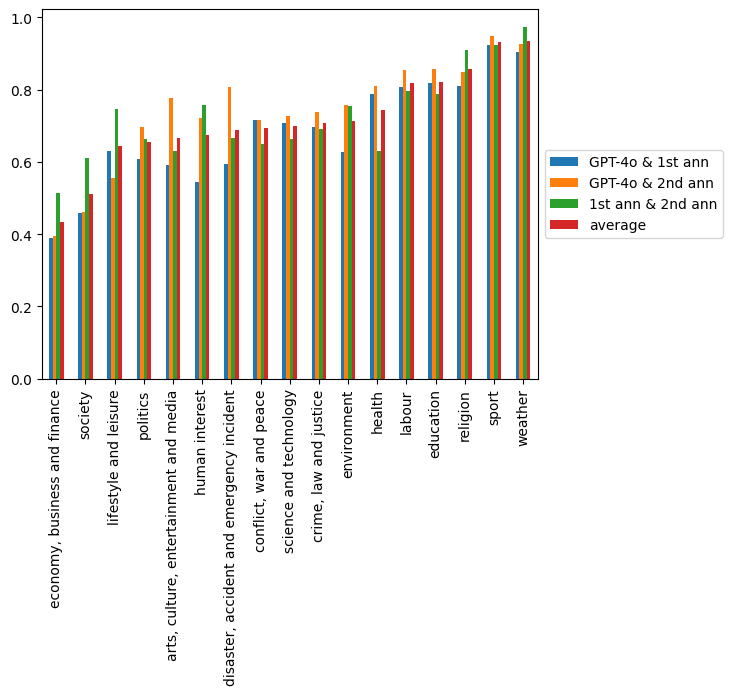

In [ ]:
label_agreement_df.plot.bar().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: >

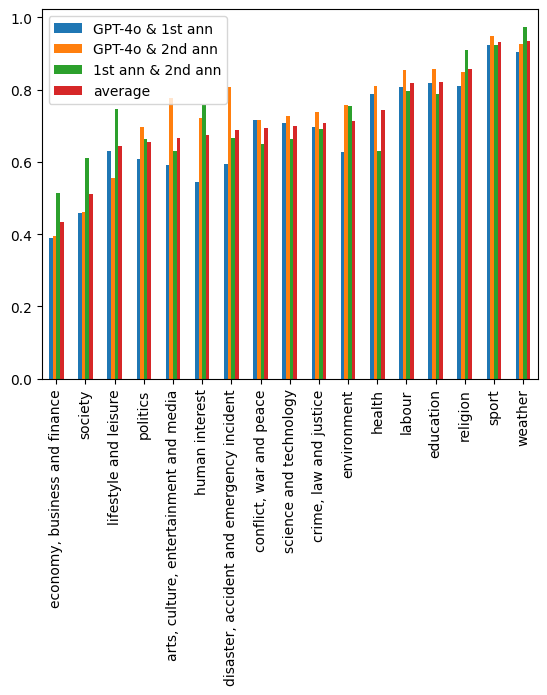

In [ ]:
label_agreement_df.plot(kind="bar", legend=True)

## Intra-Annotator Agreement

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Create a function which calculates the Krippendorff's alpha:
def krip_alpha(table, an1_column, an2_column):
    """
    Args:
    - table (DataFrame): This function takes a dataframe where the first column should be labels by the first annotator and the second labels by the other annotator.
    - an1_column: Name of the column with labels of the 1st annotator.
    - an2_column: Name of the column with labels of the 2nd annotator.

    This function prints out the nominal Krippendorff's alpha.
    """
    import krippendorff
    import numpy as np
    from collections import Counter

    # Drop NaN values if there are any
    #table = table.dropna()

    # Use only the first 2 columns
    table = table[[an1_column, an2_column]]

    table_to_list = []

    for column in table.columns:
        column_list = table[column].tolist()
        table_to_list.append(column_list)

    labels = table_to_list

    print("Number of instances: ",len(labels[0]))

    distr=dict([(b,a) for a,b in enumerate(list(Counter(labels[0]+labels[1]).keys()))])

    labels[0]=[distr[e] for e in labels[0]]
    labels[1]=[distr[e] for e in labels[1]]

    #Krippendorff's alpha
    krip = krippendorff.alpha(reliability_data=labels,level_of_measurement='nominal')
    print("Krippendorff's Alpha: ", krip)
    return krip

Prepare the sample

In [ ]:
# Open the final test sample

test_df = pd.read_json("MaCoCu-manually-annotated-test-set-with-preds.json", orient="records", lines=True)

print(test_df.shape)

test_df.head(3)

(1129, 93)


,initial_index,document_id,genre,text,pred_GPT4o,IPTC_true_multilabel,lang,batch,translation,random_pick-0,...,pred_5k-el-model-v3,match_5k-el-model-v3,pred_5k-hr-model-v2,match_5k-hr-model-v2,pred_5k-hr-model-v3,match_5k-hr-model-v3,2nd_annotation_multilabel,2nd_annotation,IPTC_true,1st_annotator_run2
0,824,CLASSLA-web.hr.3842863,News,Iza kamere\n\nFilmsku družinu ZAG posjetila je...,"arts, culture, entertainment and media","[arts, culture, entertainment and media]",hr,1st,None,"arts, culture, entertainment and media",...,"arts, culture, entertainment and media",yes,education,no,education,no,no,None,"arts, culture, entertainment and media",None
1,1949,CLASSLA-web.hr.4597011,News,Učenici osmih razreda nedavno su u sklopu tere...,education,[education],hr,1st,None,education,...,education,yes,education,yes,education,yes,no,None,education,None
2,800,CLASSLA-web.hr.4308755,News,Moto 360 – novi detalji\n\nMoto 360 već nekoli...,science and technology,[science and technology],hr,1st,Moto 360 – new details\n\nThe Moto 360 has bee...,science and technology,...,science and technology,yes,science and technology,yes,science and technology,yes,"[economy, business and finance]","economy, business and finance",science and technology,"economy, business and finance"


In [ ]:
# Filter out only instances in which we are interested in
intra_ann_df = test_df[["pred_GPT4o", "pred_GPT4o-v2", "IPTC_true", '1st_annotator_run2', "2nd_annotation"]]
intra_ann_df = intra_ann_df[intra_ann_df["1st_annotator_run2"] != np.nan]
intra_ann_df = intra_ann_df.dropna()
intra_ann_df.head(5)

,pred_GPT4o,pred_GPT4o-v2,IPTC_true,1st_annotator_run2,2nd_annotation
2,science and technology,science and technology,science and technology,"economy, business and finance","economy, business and finance"
5,"disaster, accident and emergency incident","disaster, accident and emergency incident","disaster, accident and emergency incident","disaster, accident and emergency incident","disaster, accident and emergency incident"
6,"conflict, war and peace","conflict, war and peace","conflict, war and peace","conflict, war and peace",politics
11,"economy, business and finance","economy, business and finance","economy, business and finance","economy, business and finance","economy, business and finance"
17,science and technology,science and technology,science and technology,"economy, business and finance","economy, business and finance"


In [ ]:
intra_ann_df.shape

(339, 5)

In [ ]:
agreement_results = {}

In [ ]:
from itertools import combinations, combinations_with_replacement

pairs = list(combinations(["pred_GPT4o", "pred_GPT4o-v2", "IPTC_true", '1st_annotator_run2', "2nd_annotation"], 2))
pairs

[('pred_GPT4o', 'pred_GPT4o-v2'),
 ('pred_GPT4o', 'IPTC_true'),
 ('pred_GPT4o', '1st_annotator_run2'),
 ('pred_GPT4o', '2nd_annotation'),
 ('pred_GPT4o-v2', 'IPTC_true'),
 ('pred_GPT4o-v2', '1st_annotator_run2'),
 ('pred_GPT4o-v2', '2nd_annotation'),
 ('IPTC_true', '1st_annotator_run2'),
 ('IPTC_true', '2nd_annotation'),
 ('1st_annotator_run2', '2nd_annotation')]

In [ ]:
for pair in pairs:
	agreement_results[f"{pair[0]} & {pair[1]}"] = krip_alpha(intra_ann_df, pair[0], pair[1])

agreement_results

Number of instances:  339
Krippendorff's Alpha:  0.9339659448764038
Number of instances:  339
Krippendorff's Alpha:  0.692998935727176
Number of instances:  339
Krippendorff's Alpha:  0.6992920927219729
Number of instances:  339
Krippendorff's Alpha:  0.7523992500173606
Number of instances:  339
Krippendorff's Alpha:  0.7086582109788206
Number of instances:  339
Krippendorff's Alpha:  0.7055990673618275
Number of instances:  339
Krippendorff's Alpha:  0.7712064886786076
Number of instances:  339
Krippendorff's Alpha:  0.7963853247516415
Number of instances:  339
Krippendorff's Alpha:  0.7276220865704772
Number of instances:  339
Krippendorff's Alpha:  0.7587245899211316


{'pred_GPT4o & pred_GPT4o-v2': 0.9339659448764038,
 'pred_GPT4o & IPTC_true': 0.692998935727176,
 'pred_GPT4o & 1st_annotator_run2': 0.6992920927219729,
 'pred_GPT4o & 2nd_annotation': 0.7523992500173606,
 'pred_GPT4o-v2 & IPTC_true': 0.7086582109788206,
 'pred_GPT4o-v2 & 1st_annotator_run2': 0.7055990673618275,
 'pred_GPT4o-v2 & 2nd_annotation': 0.7712064886786076,
 'IPTC_true & 1st_annotator_run2': 0.7963853247516415,
 'IPTC_true & 2nd_annotation': 0.7276220865704772,
 '1st_annotator_run2 & 2nd_annotation': 0.7587245899211316}

In [ ]:
print(pd.DataFrame({"pair": list(agreement_results.keys()), "nominal Krippendorff Alpha": list(agreement_results.values())}).sort_values(by="nominal Krippendorff Alpha", ascending=False).to_markdown(index=False))

| pair                                |   nominal Krippendorff Alpha |
|:------------------------------------|-----------------------------:|
| pred_GPT4o & pred_GPT4o-v2          |                     0.933966 |
| IPTC_true & 1st_annotator_run2      |                     0.796385 |
| pred_GPT4o-v2 & 2nd_annotation      |                     0.771206 |
| 1st_annotator_run2 & 2nd_annotation |                     0.758725 |
| pred_GPT4o & 2nd_annotation         |                     0.752399 |
| IPTC_true & 2nd_annotation          |                     0.727622 |
| pred_GPT4o-v2 & IPTC_true           |                     0.708658 |
| pred_GPT4o-v2 & 1st_annotator_run2  |                     0.705599 |
| pred_GPT4o & 1st_annotator_run2     |                     0.699292 |
| pred_GPT4o & IPTC_true              |                     0.692999 |
